# 1. Import Dependencies

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout, Reshape, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shap
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import boxcox


# 2. Load Datasets

In [43]:
# Load datasets
combined_stock_data = pd.read_csv(r'C:\Users\kicki\Data_Scientist_projects\Stock_prediction_AI\nasdaq_tech_AI\data\combined_stock_data.csv')
sentiment_data = pd.read_csv(r'C:\Users\kicki\Data_Scientist_projects\Stock_prediction_AI\nasdaq_tech_AI\data\combined_sentiment_data.csv')
macroeconomic_data = pd.read_csv(r'C:\Users\kicki\Data_Scientist_projects\Stock_prediction_AI\nasdaq_tech_AI\data\macroeconomic_data.csv')
preprocessed_stock_data = pd.read_csv(r'C:\Users\kicki\Data_Scientist_projects\Stock_prediction_AI\nasdaq_tech_AI\data\preprocessed_stock_data.csv')
stock_data_with_indicators = pd.read_csv(r'C:\Users\kicki\Data_Scientist_projects\Stock_prediction_AI\nasdaq_tech_AI\data\stock_data_with_indicators.csv')

In [44]:
print(stock_data_with_indicators.head)

<bound method NDFrame.head of              Date        Open        High         Low       Close  \
0      1984-09-07    0.099824    0.101049    0.098619    0.099824   
1      1984-09-10    0.099824    0.100130    0.097424    0.099232   
2      1984-09-11    0.100130    0.102846    0.100130    0.101049   
3      1984-09-12    0.101049    0.101641    0.098007    0.098007   
4      1984-09-13    0.103460    0.103754    0.103460    0.103460   
...           ...         ...         ...         ...         ...   
50011  2024-10-23  762.830000  763.789900  744.260000  749.290000   
50012  2024-10-24  751.970000  755.820000  746.250000  754.550000   
50013  2024-10-25  756.170000  768.500000  753.530000  754.680000   
50014  2024-10-28  758.680000  758.680000  747.880000  749.120000   
50015  2024-10-29  750.430000  763.880000  748.010000  759.280000   

             Volume Symbol        MA_7       MA_21    SMA_50  ...  lower_band  \
0      9.859472e+07   AAPL         NaN         NaN       NaN

In [45]:
print(combined_stock_data.head)

<bound method NDFrame.head of              Date        Open        High         Low       Close  \
0      1984-09-07    0.099824    0.101049    0.098619    0.099824   
1      1984-09-10    0.099824    0.100130    0.097424    0.099232   
2      1984-09-11    0.100130    0.102846    0.100130    0.101049   
3      1984-09-12    0.101049    0.101641    0.098007    0.098007   
4      1984-09-13    0.103460    0.103754    0.103460    0.103460   
...           ...         ...         ...         ...         ...   
50011  2024-10-23  762.830000  763.789900  744.260000  749.290000   
50012  2024-10-24  751.970000  755.820000  746.250000  754.550000   
50013  2024-10-25  756.170000  768.500000  753.530000  754.680000   
50014  2024-10-28  758.680000  758.680000  747.880000  749.120000   
50015  2024-10-29  750.430000  763.880000  748.010000  759.280000   

             Volume Symbol  
0      9.859472e+07   AAPL  
1      7.652559e+07   AAPL  
2      1.804519e+08   AAPL  
3      1.576401e+08   AAP

In [46]:
print(macroeconomic_data.head)

<bound method NDFrame.head of            Date   PPIACO  CPIAUCSL  UNRATE        GDP  DGS2 DCOILWTICO DGS10  \
0    2015-01-01  192.000   234.747     5.7  18063.529     .          .     .   
1    2015-02-01  191.100   235.342     5.5  18063.529     .          .     .   
2    2015-03-01  191.500   235.976     5.4  18063.529     .          .     .   
3    2015-04-01  190.900   236.222     5.4  18279.784  0.55      50.12  1.87   
4    2015-05-01  193.400   237.001     5.6  18279.784  0.60      59.10  2.12   
..          ...      ...       ...     ...        ...   ...        ...   ...   
112  2024-05-01  255.313   313.225     4.0  29016.714  4.96       80.7  4.63   
113  2024-06-01  255.870   313.049     4.1  29016.714  4.96       80.7  4.63   
114  2024-07-01  257.337   313.534     4.3  29016.714  4.77       84.7  4.48   
115  2024-08-01  255.487   314.121     4.2  29016.714  4.16      77.74  3.99   
116  2024-09-01  252.526   314.686     4.1  29016.714  4.16      77.74  3.99   

        R

# 3. Combine Datasets

In [47]:
# Combine datasets
combined_data = pd.merge(combined_stock_data, sentiment_data, on=['Date', 'Symbol'], how='left')
combined_data = pd.merge(combined_data, macroeconomic_data, on='Date', how='left')
combined_data = pd.merge(combined_data, preprocessed_stock_data, on=['Date', 'Symbol'], how='left')
combined_data = pd.merge(combined_data, stock_data_with_indicators, on=['Date', 'Symbol'], how='left')
combined_data.fillna(0, inplace=True)


# 4. EDA

In [48]:
print("Basic Statistics:\n", combined_data.describe())
print("Missing Values:\n", combined_data.isna().sum())

Basic Statistics:
              Open_x        High_x         Low_x       Close_x      Volume_x  \
count  50016.000000  50016.000000  50016.000000  50016.000000  5.001600e+04   
mean      60.963684     61.780752     60.130048     60.976462  2.132240e+08   
std      106.964668    108.392722    105.489604    106.969889  3.249996e+08   
min        0.032106      0.032563      0.030496      0.031191  0.000000e+00   
25%        1.589125      1.618820      1.556160      1.590872  3.709906e+07   
50%       15.416350     15.631000     15.192700     15.402500  9.287317e+07   
75%       63.295000     63.985425     62.600750     63.344000  2.452743e+08   
max      765.760000    773.000000    761.120000    772.070000  1.010038e+10   

       Sentiment_x        PPIACO      CPIAUCSL        UNRATE           GDP  \
count      50016.0  50016.000000  50016.000000  50016.000000  50016.000000   
mean           0.0      2.711686      3.327611      0.060013    281.903724   
std            0.0     24.361473   

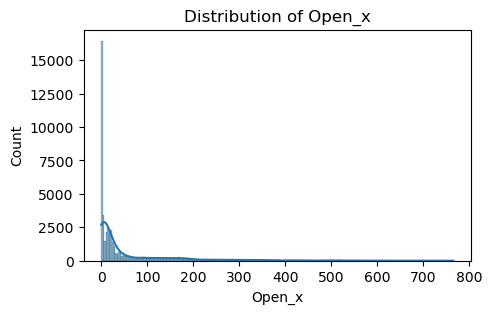

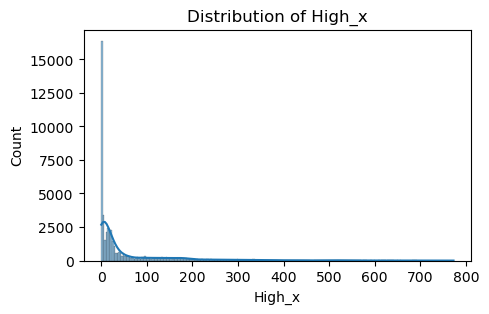

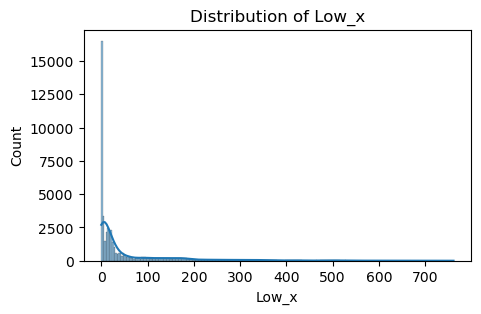

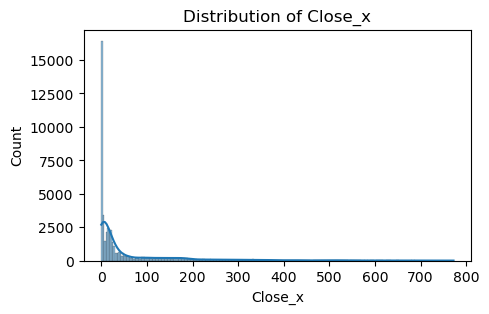

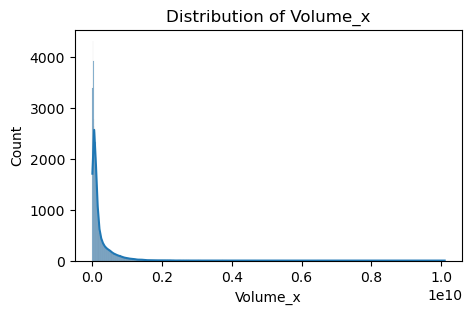

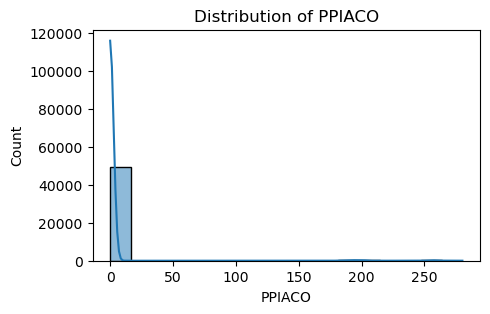

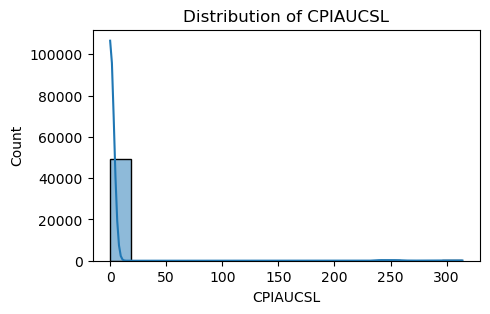

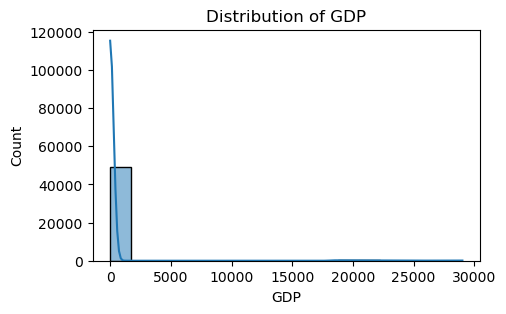

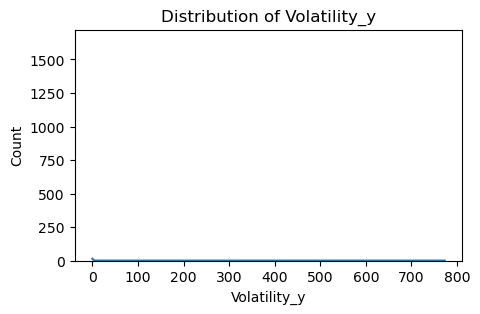

In [49]:
# Visualize distributions of key numerical features
numerical_features = ['Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'PPIACO', 'CPIAUCSL', 'GDP', 'Volatility_y']
for feature in numerical_features:
    plt.figure(figsize=(5, 3))
    sns.histplot(combined_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


In [50]:
# Apply log transformation to reduce skewness
skewed_features = ['Volume_x', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'GDP', 'PPIACO', 'CPIAUCSL', 'Volatility_y']
for feature in skewed_features:
    combined_data[feature] = np.log1p(combined_data[feature])


In [51]:
# Select numeric columns to scale
numeric_features = combined_data.select_dtypes(include=['float64', 'int64']).columns

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform the features
combined_data[numeric_features] = scaler.fit_transform(combined_data[numeric_features])



In [52]:
# Cap extreme outliers at the 99th percentile
for feature in skewed_features:
    cap = combined_data[feature].quantile(0.99)
    combined_data[feature] = np.where(combined_data[feature] > cap, cap, combined_data[feature])


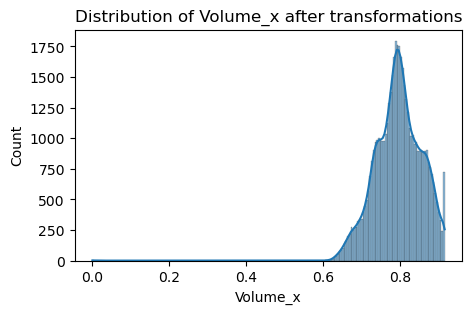

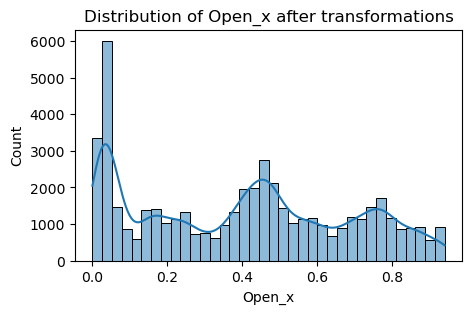

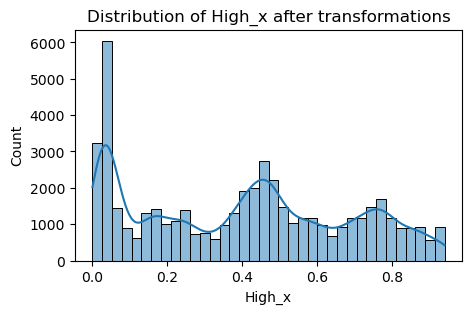

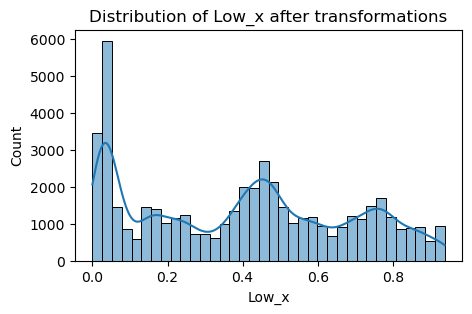

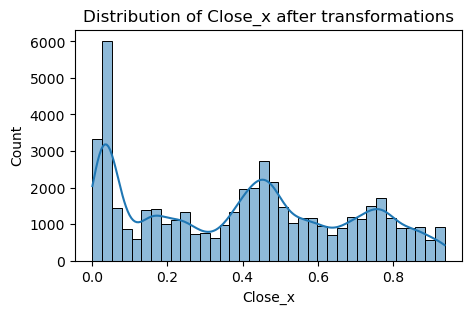

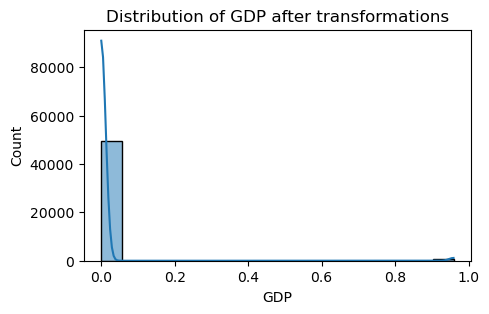

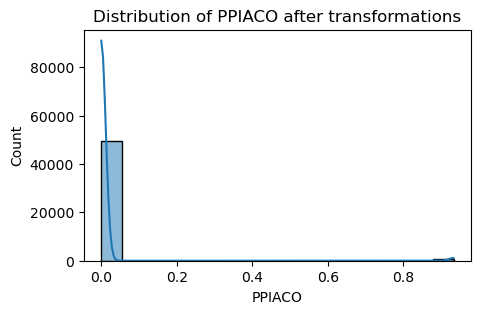

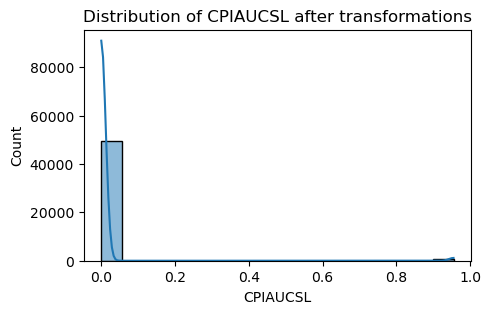

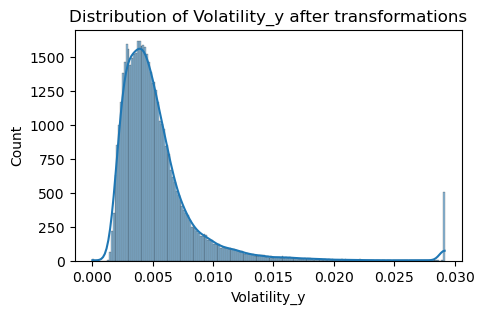

In [53]:
# Recheck distributions after log transformation, capping, and scaling
for feature in skewed_features:
    plt.figure(figsize=(5, 3,))
    sns.histplot(combined_data[feature], kde=True)
    plt.title(f'Distribution of {feature} after transformations')
    plt.show()

In [54]:
# Check skewness and kurtosis after transformation
for feature in skewed_features:
    skewness = combined_data[feature].skew()
    kurtosis = combined_data[feature].kurt()
    print(f'{feature} - Skewness: {skewness}, Kurtosis: {kurtosis}')


Volume_x - Skewness: -0.3995504820614711, Kurtosis: 2.7799074195332434
Open_x - Skewness: 0.13856307233230447, Kurtosis: -1.1869211321800068
High_x - Skewness: 0.1363466237098206, Kurtosis: -1.185493074989619
Low_x - Skewness: 0.1408028634881956, Kurtosis: -1.1885627154637068
Close_x - Skewness: 0.13848861195031673, Kurtosis: -1.1870047504510022
GDP - Skewness: 8.784729685902535, Kurtosis: 75.1746067252155
PPIACO - Skewness: 8.784778558510267, Kurtosis: 75.17575622770272
CPIAUCSL - Skewness: 8.784731715934987, Kurtosis: 75.17465454981995
Volatility_y - Skewness: 3.6062788192029505, Kurtosis: 17.956727939100816


In [55]:
# Check for missing values
missing_values = combined_data.isna().sum()
print("Missing Values after transformation:\n", missing_values[missing_values > 0])


Missing Values after transformation:
 Series([], dtype: int64)


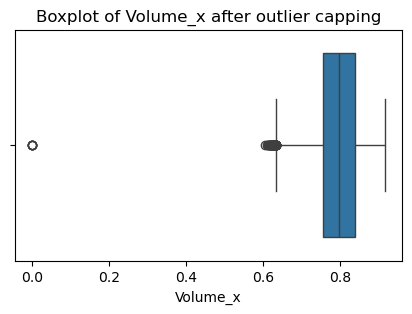

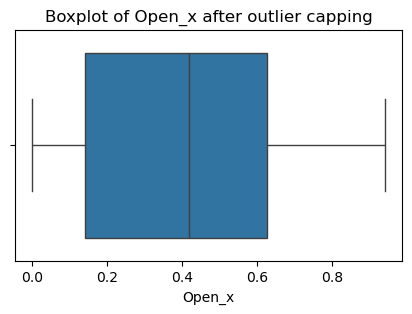

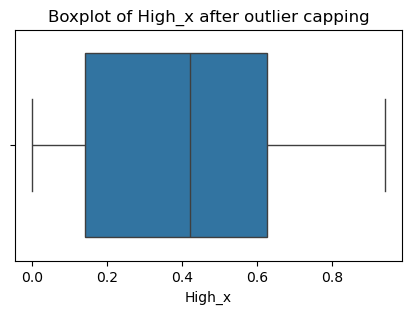

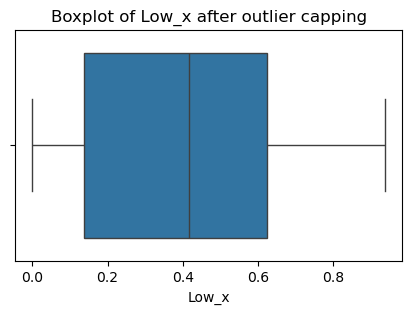

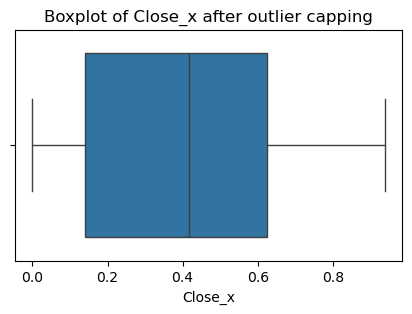

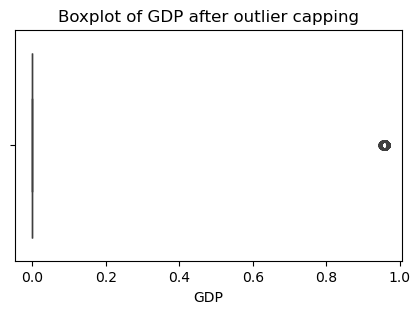

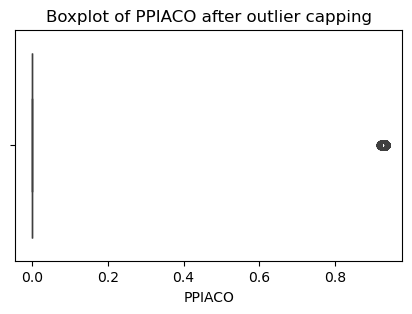

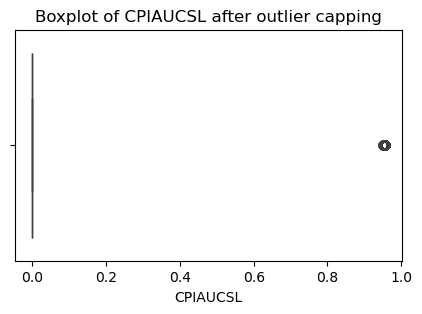

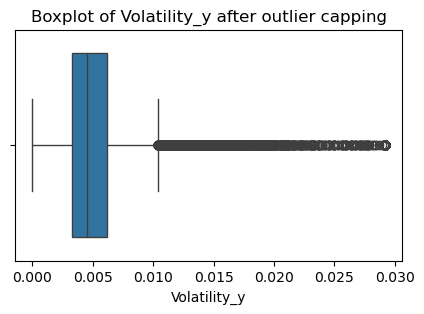

In [56]:
# Inspect potential outliers after capping
for feature in skewed_features:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=combined_data[feature])
    plt.title(f'Boxplot of {feature} after outlier capping')
    plt.show()

In [57]:
# Further transformation

# Apply log1p and/or Box-Cox for heavily skewed features
combined_data['GDP'] = np.log1p(combined_data['GDP'])
combined_data['PPIACO'] = np.log1p(combined_data['PPIACO'])
combined_data['CPIAUCSL'] = np.log1p(combined_data['CPIAUCSL'])

# For Volatility_y, you could try a Box-Cox transformation
# Ensure the data is positive for Box-Cox transformation
combined_data['Volatility_y'] = combined_data['Volatility_y'].replace(0, combined_data['Volatility_y'].mean())  # Replace zeros
combined_data['Volatility_y'], _ = boxcox(combined_data['Volatility_y'])


In [58]:
# Recheck skewness and kurtosis after transformation
for feature in skewed_features:
    skewness = combined_data[feature].skew()
    kurtosis = combined_data[feature].kurt()
    print(f'{feature} - Skewness: {skewness}, Kurtosis: {kurtosis}')

Volume_x - Skewness: -0.3995504820614711, Kurtosis: 2.7799074195332434
Open_x - Skewness: 0.13856307233230447, Kurtosis: -1.1869211321800068
High_x - Skewness: 0.1363466237098206, Kurtosis: -1.185493074989619
Low_x - Skewness: 0.1408028634881956, Kurtosis: -1.1885627154637068
Close_x - Skewness: 0.13848861195031673, Kurtosis: -1.1870047504510022
GDP - Skewness: 8.784719886369064, Kurtosis: 75.17437596327348
PPIACO - Skewness: 8.784746375800287, Kurtosis: 75.17499940393722
CPIAUCSL - Skewness: 8.784720986206564, Kurtosis: 75.17440187903885
Volatility_y - Skewness: -0.006910511970715722, Kurtosis: 0.0705475703048335


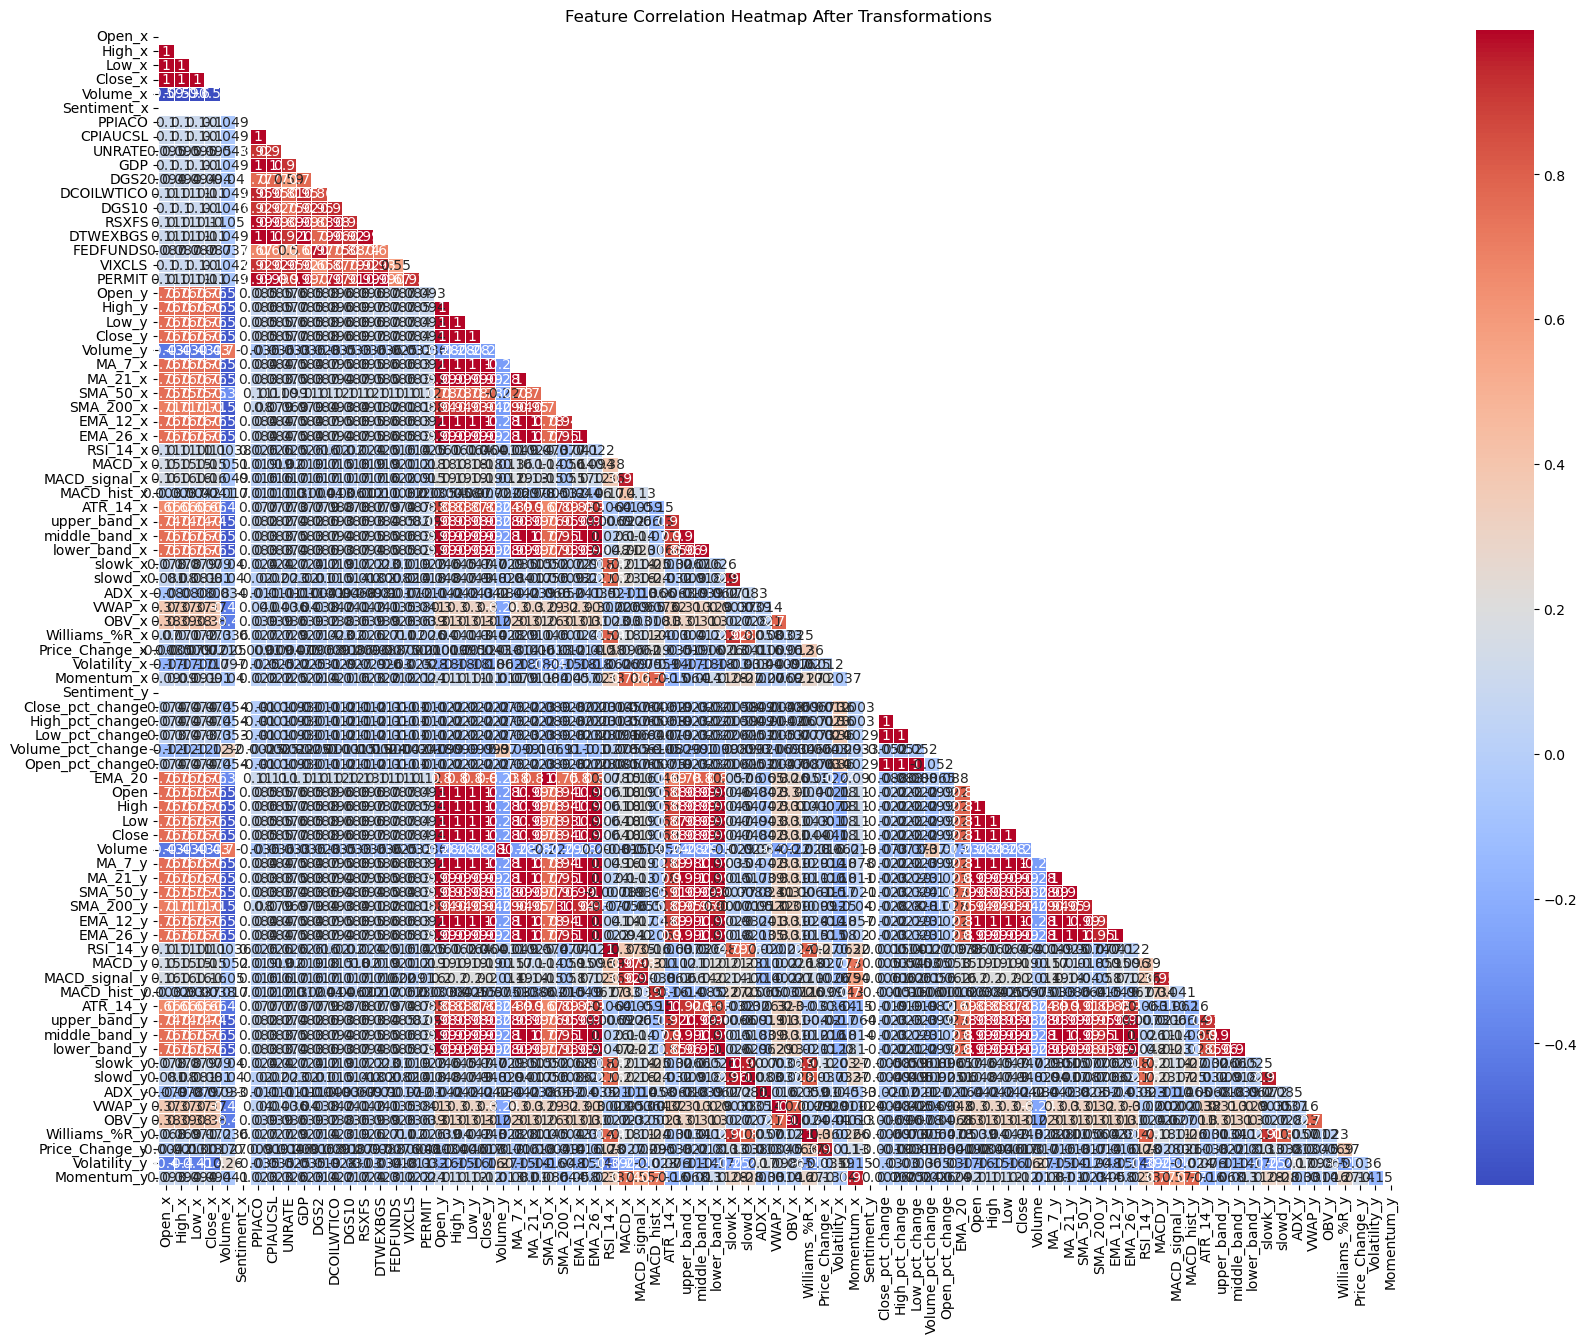

In [59]:
# Drop non-numeric columns for heatmap calculation
numeric_data = combined_data.drop(columns=['Date', 'Symbol'])

# Scale the data
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(numeric_data), columns=numeric_data.columns)

# Correlation Heatmap with reduced size for better readability
plt.figure(figsize=(20, 15))
corr_matrix = scaled_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap After Transformations')
plt.show()

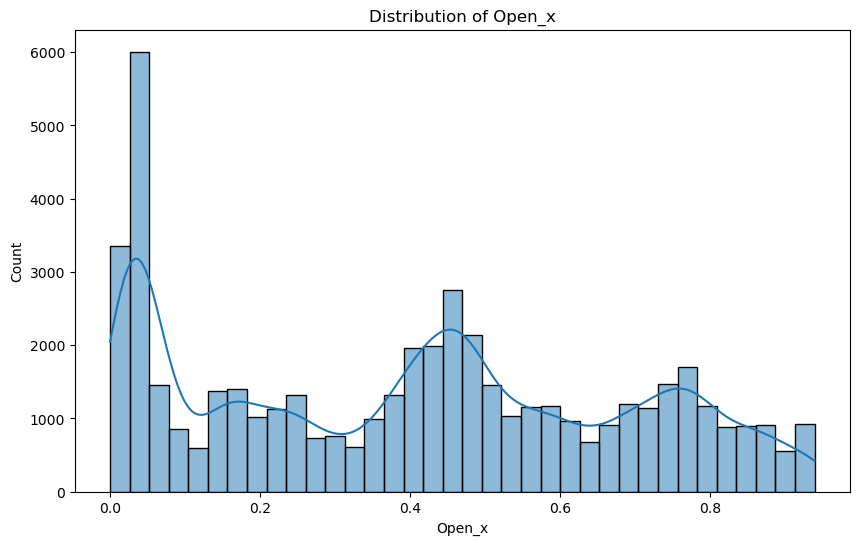

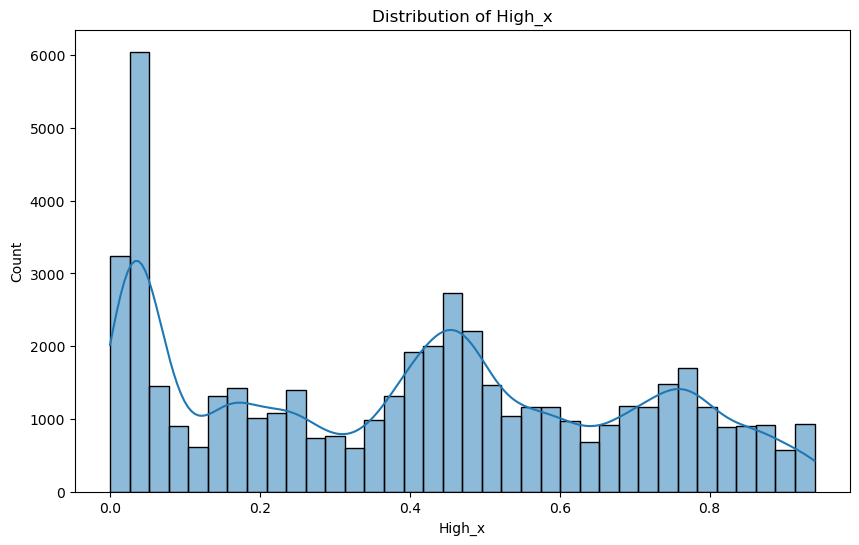

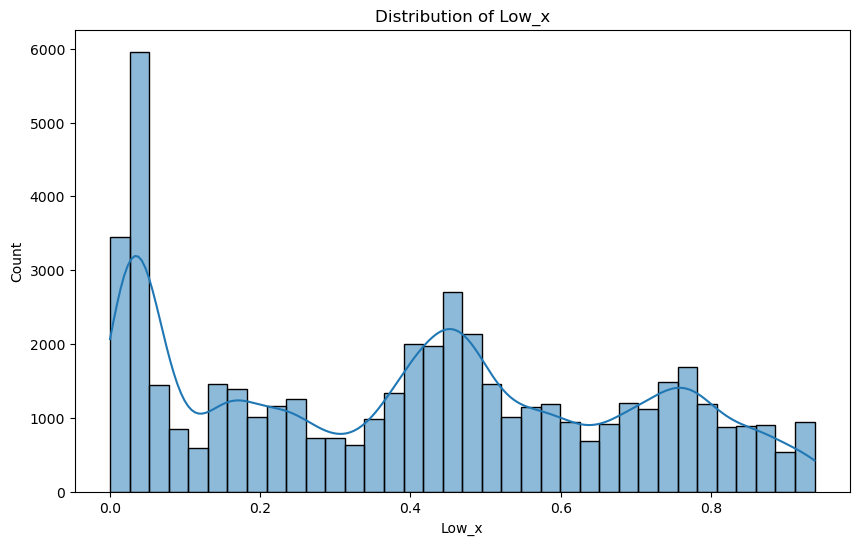

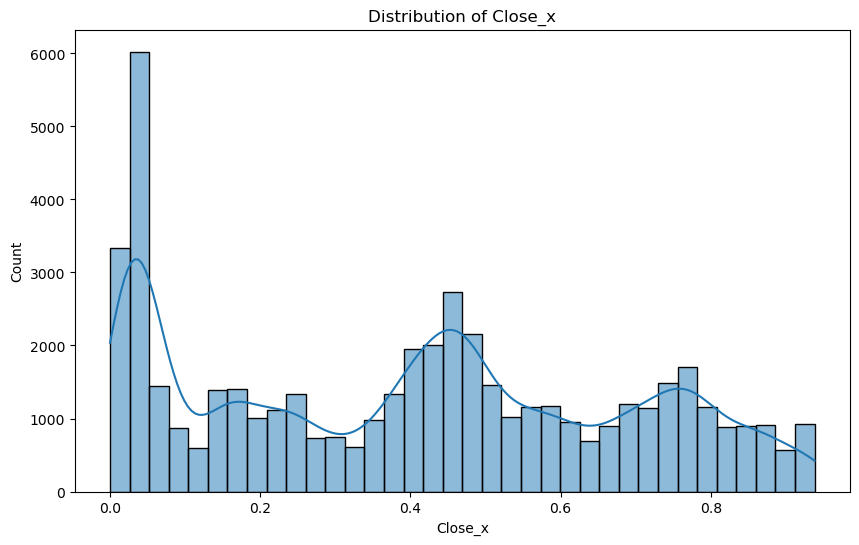

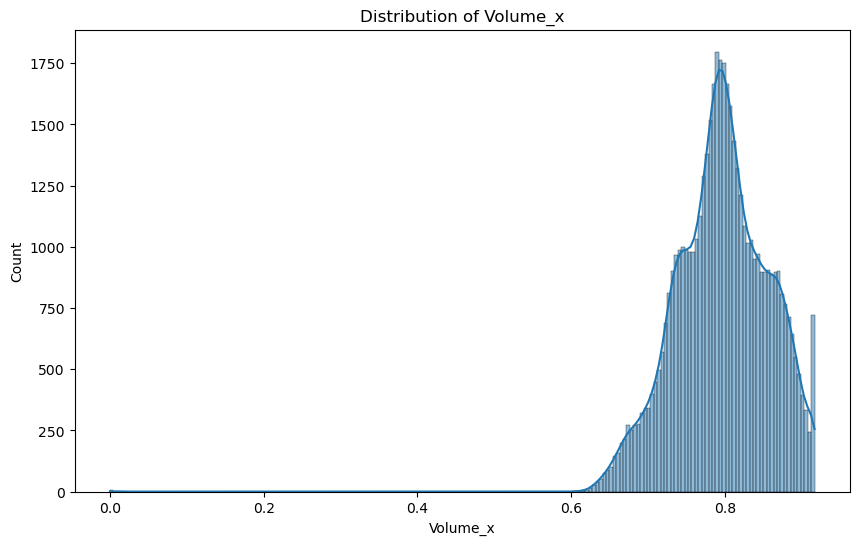

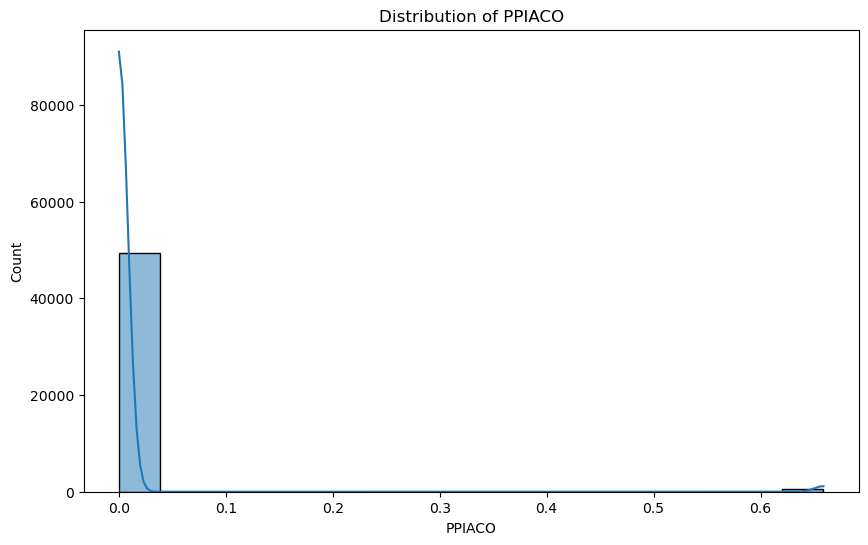

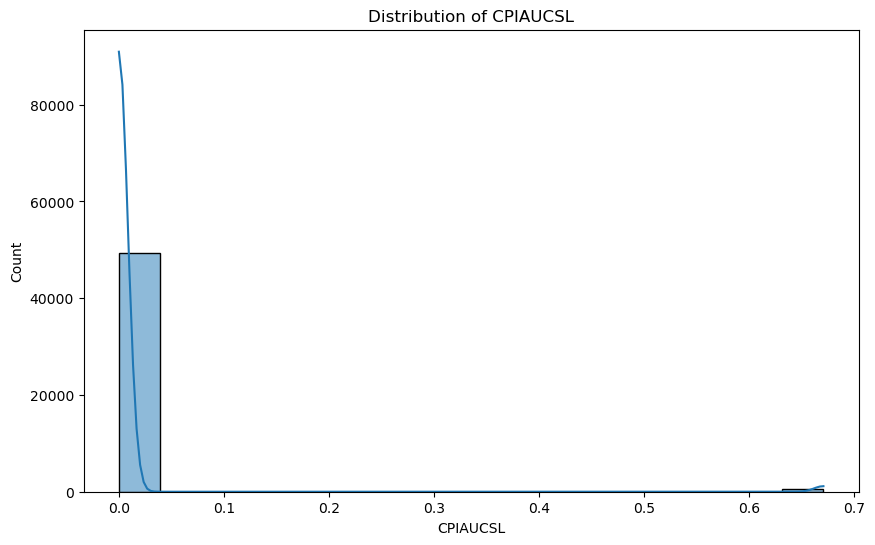

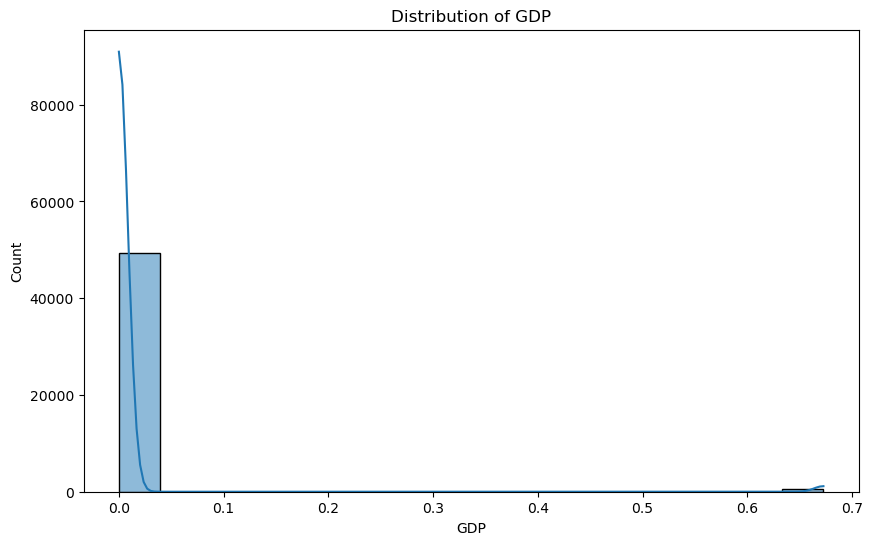

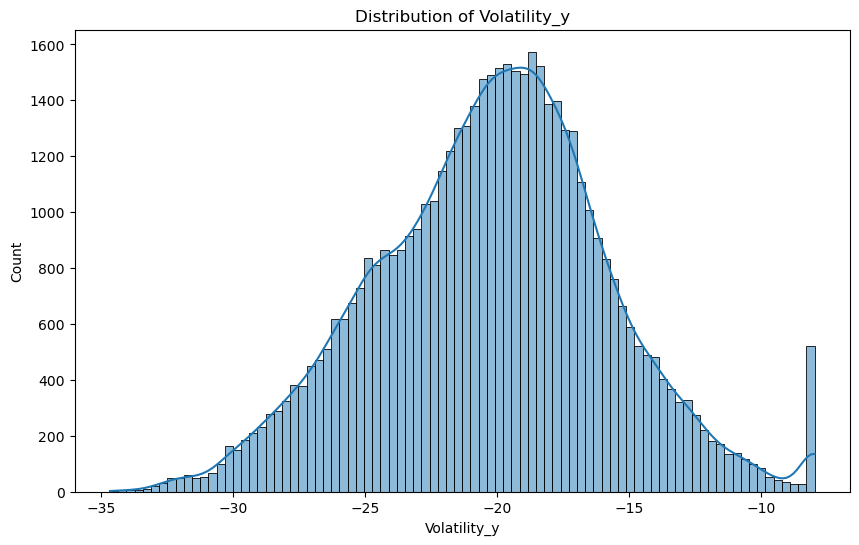

In [60]:
# Visualize distributions of key numerical features
numerical_features = ['Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'PPIACO', 'CPIAUCSL', 'GDP', 'Volatility_y']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(combined_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

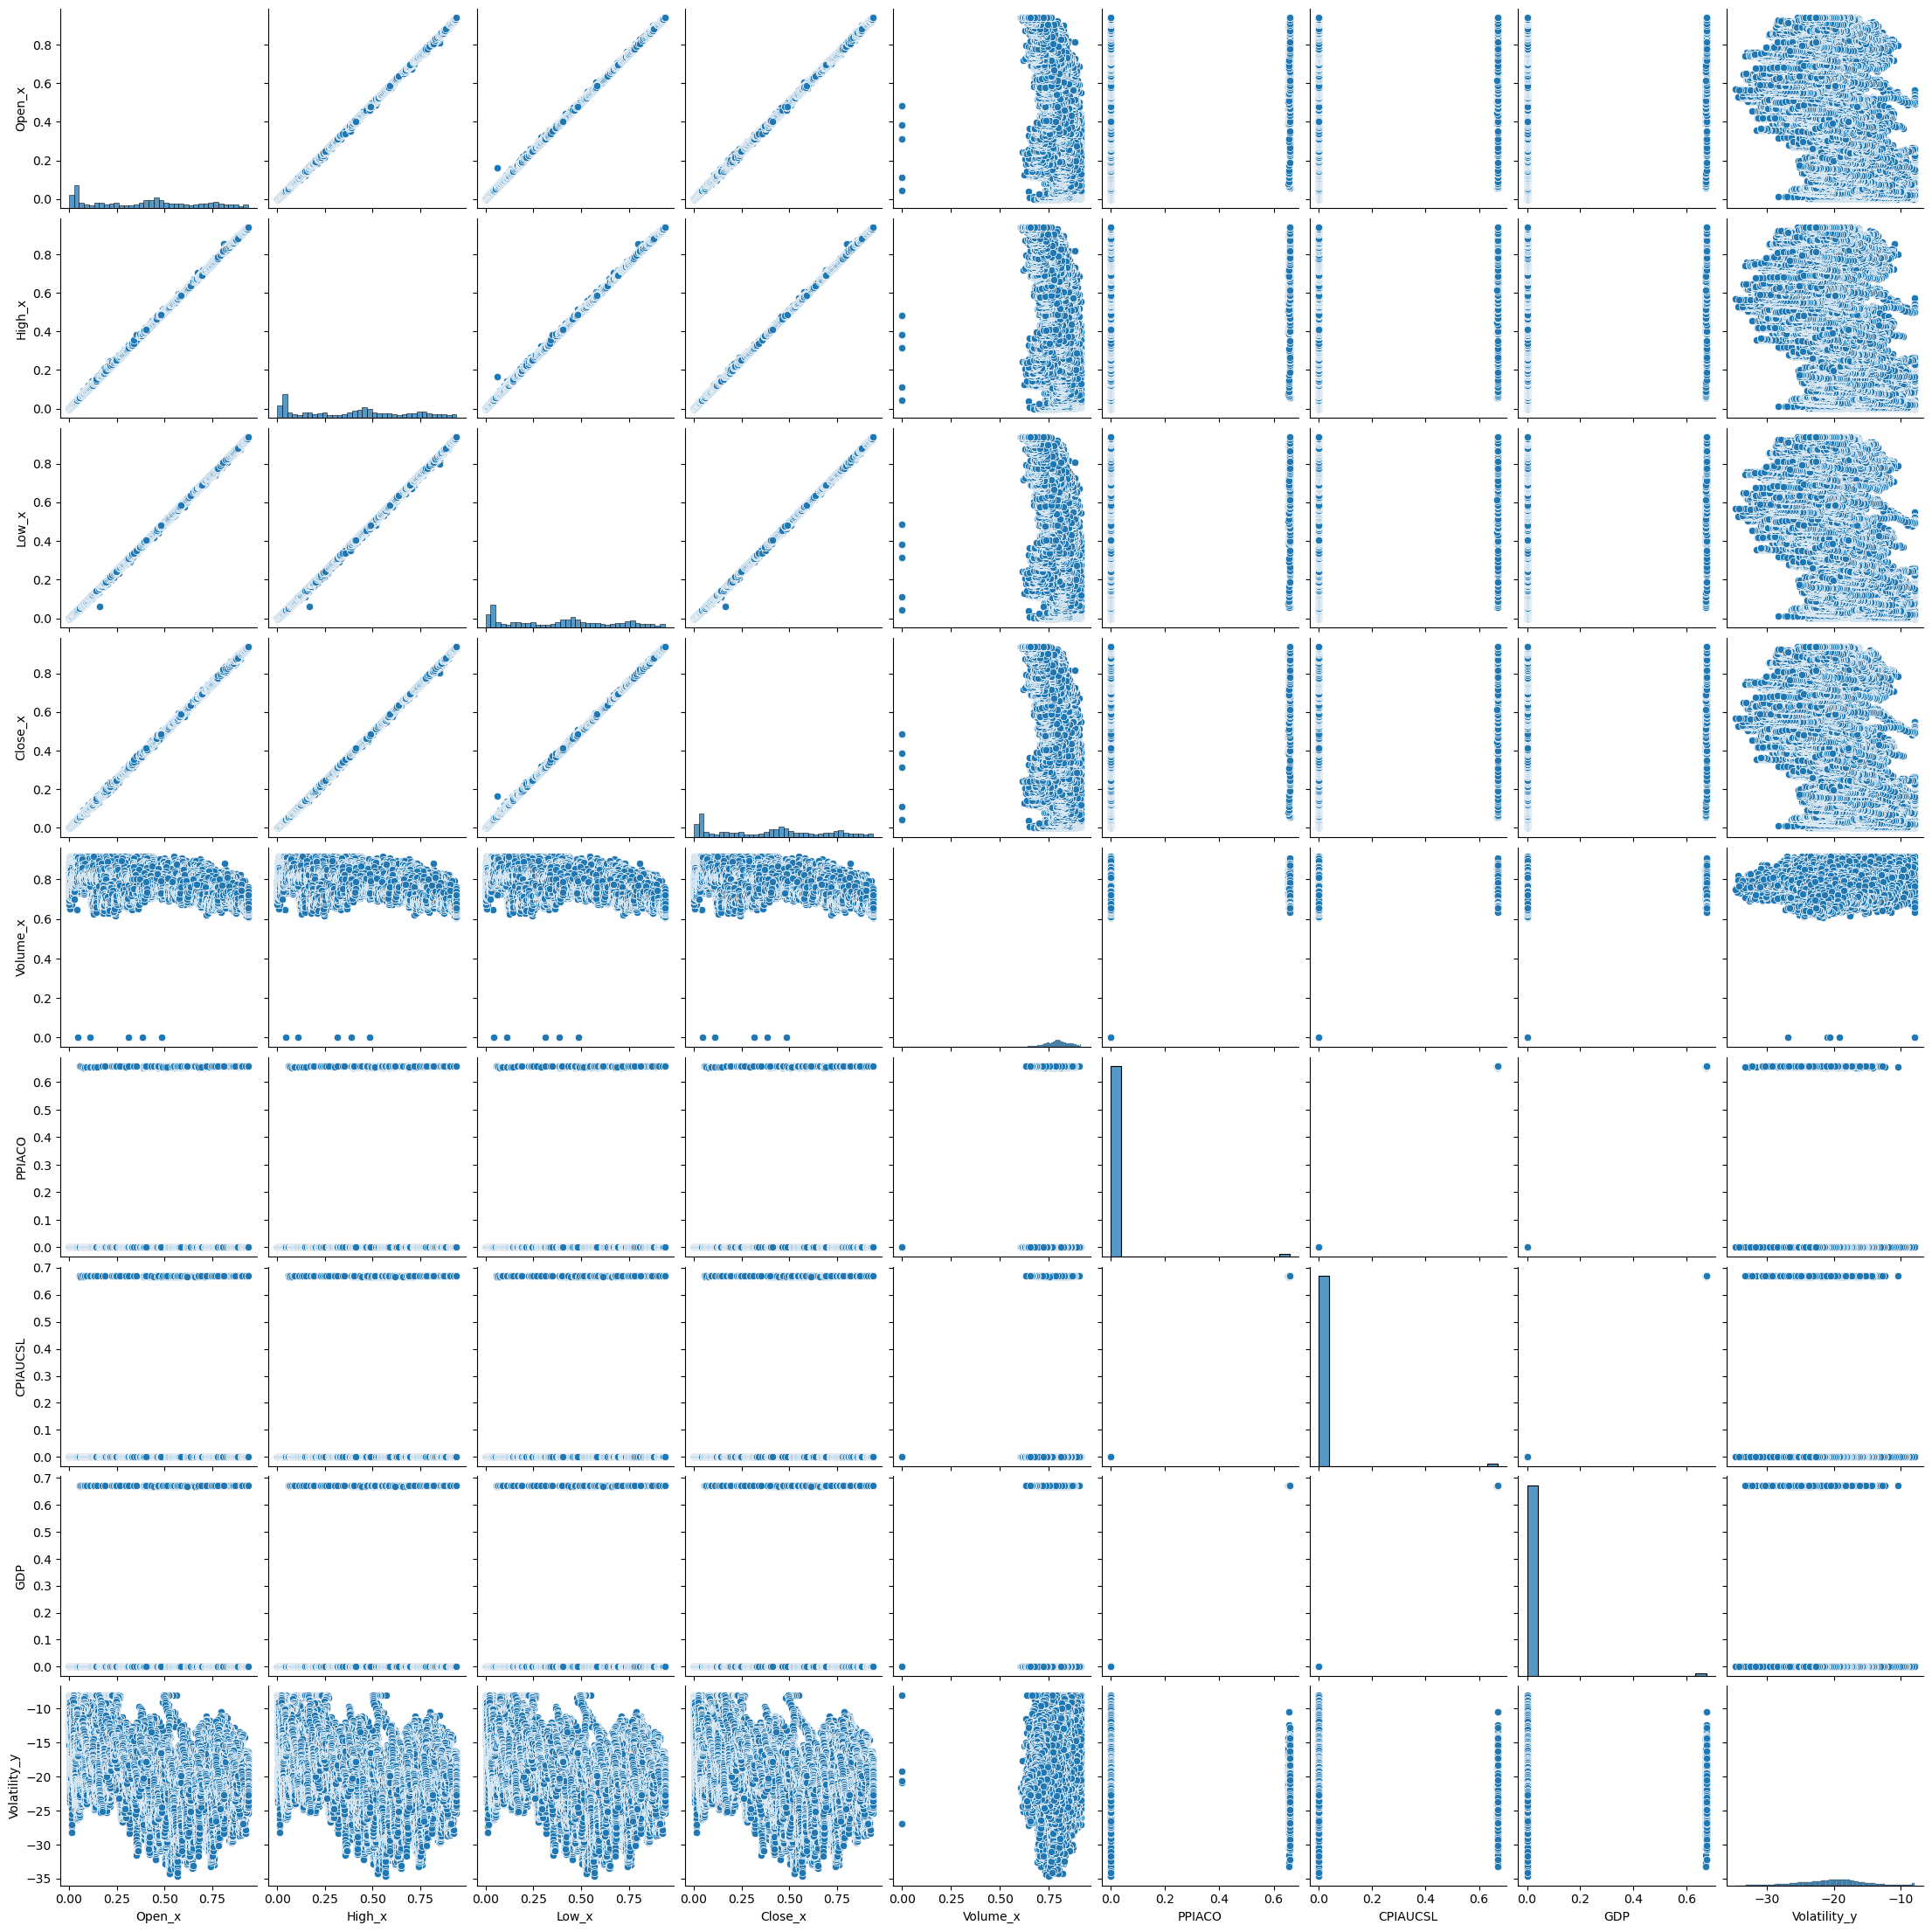

In [61]:
# Pairplot to understand relationships between key features
sns.pairplot(combined_data[numerical_features])
plt.show()

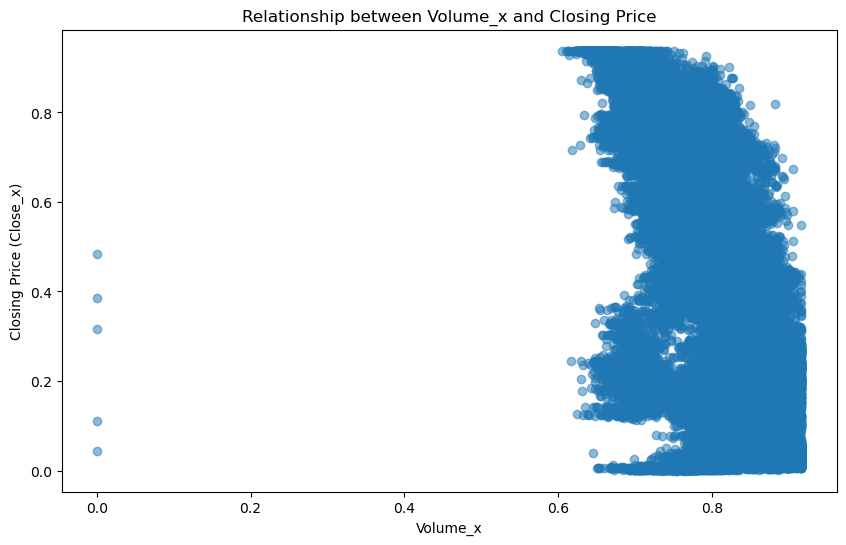

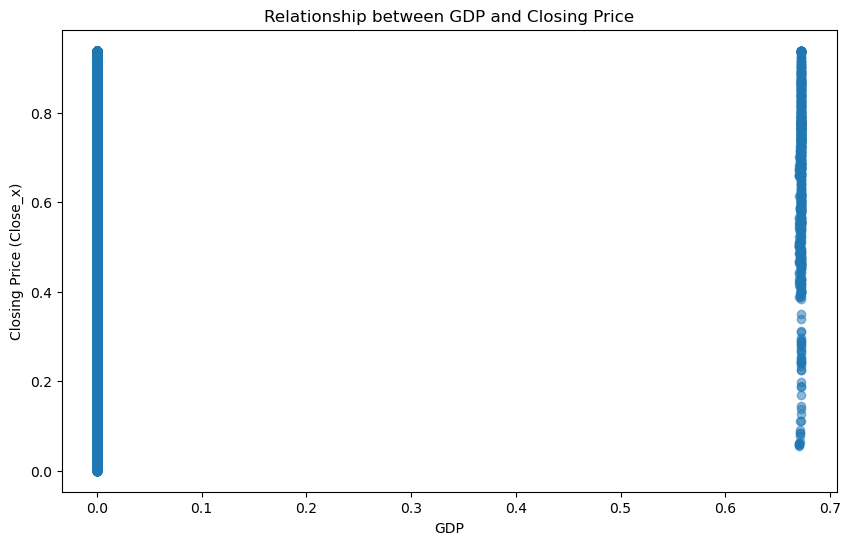

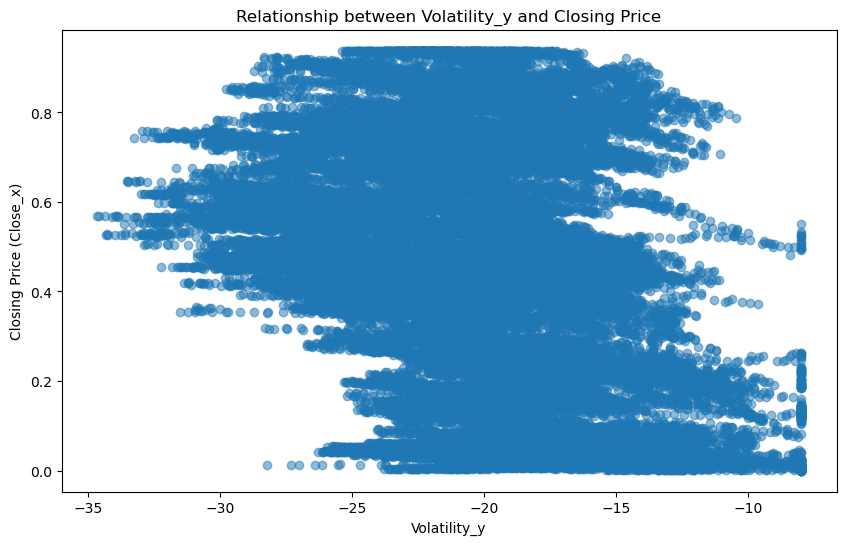

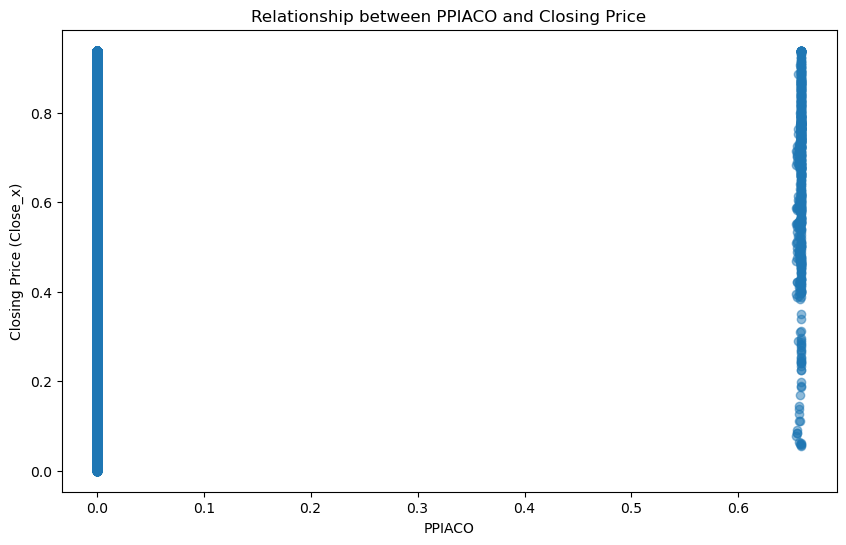

In [62]:
# Scatter plots to understand relationships between features and the target ('Close_x')
important_features = ['Volume_x', 'GDP', 'Volatility_y', 'PPIACO']
for feature in important_features:
    plt.figure(figsize=(10, 6))
    plt.scatter(combined_data[feature], combined_data['Close_x'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Closing Price (Close_x)')
    plt.title(f'Relationship between {feature} and Closing Price')
    plt.show()

# 5. Data process

In [ ]:
# Removing features with high correlation (above 0.9) to reduce multicollinearity
corr_threshold = 0.9
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_columns = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]
selected_features = combined_data.drop(columns=drop_columns + ['Date', 'Symbol', 'Close'])
labels = combined_data['Close']

In [ ]:
# Feature selection using RandomForest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(selected_features, labels)
feature_importances = pd.Series(rf.feature_importances_, index=selected_features.columns)
important_features = feature_importances[feature_importances > 0.01].index
selected_features = selected_features[important_features]

In [66]:
# Scaling selected features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(selected_features)

In [67]:
# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=0.95)  # Retain 95% of the variance
pca_features = pca.fit_transform(scaled_features)

# 6. Train-Test Split and Scaling

In [68]:
# Split data into training and testing sets
train_size = int(len(pca_features) * 0.8)
X_train, X_test = pca_features[:train_size], pca_features[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

In [69]:
# Reshape data for CNN-LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 7. Create Model

In [70]:
# Build the hybrid CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())  
model.add(Flatten())
model.add(Reshape((1, 64)))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.3))  
model.add(LSTM(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  
model.add(Dropout(0.3))  
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


# 8. Train Model

In [71]:
# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

In [72]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping, lr_reduction])

Epoch 1/50
1251/1251 - 27s - loss: 0.0306 - mae: 0.0178 - val_loss: 9.0531e-04 - val_mae: 0.0162 - lr: 0.0010 - 27s/epoch - 22ms/step
Epoch 2/50
1251/1251 - 21s - loss: 9.9659e-04 - mae: 0.0150 - val_loss: 0.0012 - val_mae: 0.0165 - lr: 0.0010 - 21s/epoch - 17ms/step
Epoch 3/50
1251/1251 - 21s - loss: 8.5385e-04 - mae: 0.0142 - val_loss: 0.0016 - val_mae: 0.0229 - lr: 0.0010 - 21s/epoch - 17ms/step
Epoch 4/50
1251/1251 - 24s - loss: 8.4522e-04 - mae: 0.0143 - val_loss: 6.7341e-04 - val_mae: 0.0146 - lr: 0.0010 - 24s/epoch - 19ms/step
Epoch 5/50
1251/1251 - 21s - loss: 8.4670e-04 - mae: 0.0143 - val_loss: 0.0054 - val_mae: 0.0374 - lr: 0.0010 - 21s/epoch - 17ms/step
Epoch 6/50
1251/1251 - 21s - loss: 9.0504e-04 - mae: 0.0144 - val_loss: 0.0016 - val_mae: 0.0193 - lr: 0.0010 - 21s/epoch - 17ms/step
Epoch 7/50
1251/1251 - 23s - loss: 8.7821e-04 - mae: 0.0150 - val_loss: 7.4488e-04 - val_mae: 0.0176 - lr: 0.0010 - 23s/epoch - 18ms/step
Epoch 8/50
1251/1251 - 21s - loss: 6.5996e-04 - mae: 0

# 9. Evaluate Model

In [73]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test MAE: {mae}")

Test Loss: 0.0001339439331786707, Test MAE: 0.00446701655164361


# 10. Visualize Model

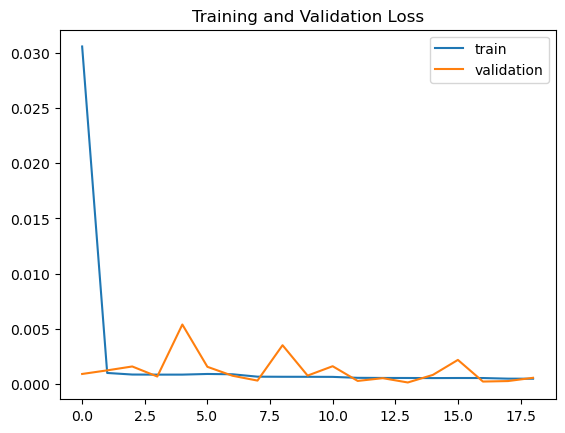

In [74]:
# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


# 11. Make Predictions

313/313 [==============================] - 1s 3ms/step


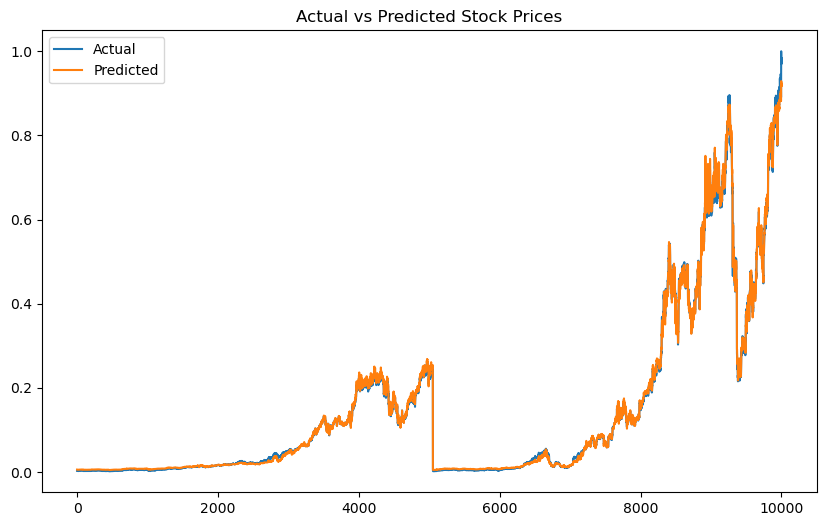

In [81]:
# Make predictions
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# 12. Evaluation Metrics

In [76]:
# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 0.007099057595395677
MAPE: 0.23594804833503147


# 13. Backtesting

In [ ]:
# Backtesting (Placeholder)
# Implement backtesting logic to simulate model performance in a trading scenario
print("Backtesting results")
